In [2]:
import scrapy
from scrapy.crawler import CrawlerProcess

class YelpSpider(scrapy.Spider):
    
    name = "YS"

    start_urls = [
        'https://www.yelp.com/search?find_loc=Seattle,+WA&start=0&cflt=indpak',      
    ]

    
    def parse(self, response):
        
        #//li is the identifier used for each listing (per inspect-->elements )
        for listing in response.xpath('//li[@class="regular-search-result"]'):
 

                yield {
                    'name' : listing.xpath(".//span[@class='indexed-biz-name']/a/span/text()").extract_first(),
                    'rating' : listing.xpath(".//div[@class='biz-rating biz-rating-large clearfix']//@title").extract_first(),
                    'price' : listing.xpath(".//span[@class='business-attribute price-range']/text()").extract_first(),
                    'reviews' : listing.xpath(".//span[@class='review-count rating-qualifier']/text()").extract_first(),
                    'categories' : listing.xpath(".//span[@class='category-str-list']//a/text()").extract(),
                    }
        
        for i in [1,2,3,4,5]:
            next_page =  'https://www.yelp.com/search?find_loc=Seattle,+WA&start={}&cflt=indpak'.format(i*30)
            if next_page is not None:
                yield scrapy.Request(next_page, callback=self.parse)
            
    
process = CrawlerProcess({
    'FEED_FORMAT': 'json',    
    'FEED_URI': 'my_yelptest.json',    
    'ROBOTSTXT_OBEY': False,
    'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True,
    'LOG_ENABLED': False,    
    'CLOSESPIDER_PAGECOUNT' : 100
})
                                         

# Starting the crawler with our spider.
process.crawl(YelpSpider)
process.start()
print('Done!')

Done!


In [3]:
import pandas as pd

yelp_df=pd.read_json('my_yelptest.json', orient='records')
print(yelp_df.shape)


(153, 5)


In [4]:
print(yelp_df.head())

                           categories                       name price  \
0                            [Indian]             Taste of India    $$   
1             [Indian, Bars, Buffets]  Daawat Indian Grill & Bar    $$   
2  [Indian, Himalayan/Nepalese, Bars]             Annapurna Cafe    $$   
3       [Indian, Mediterranean, Soup]              Saffron Grill    $$   
4                            [Indian]                   Nirmal’s    $$   

            rating                           reviews  
0  4.5 star rating  \n            1278 reviews\n      
1  4.0 star rating   \n            376 reviews\n      
2  4.0 star rating   \n            755 reviews\n      
3  4.0 star rating   \n            959 reviews\n      
4  3.5 star rating   \n            349 reviews\n      


In [5]:
yelp_df['reviews'] = yelp_df['reviews'].str.extract('(\d+)')

In [9]:
yelp_df.rename(columns={'rating':'rating_star'}, inplace=True)

In [11]:
yelp_df['rating_star'] = yelp_df['rating_star'].str.strip(' star rating')

In [12]:
print(yelp_df.head())

                           categories                       name price  \
0                            [Indian]             Taste of India    $$   
1             [Indian, Bars, Buffets]  Daawat Indian Grill & Bar    $$   
2  [Indian, Himalayan/Nepalese, Bars]             Annapurna Cafe    $$   
3       [Indian, Mediterranean, Soup]              Saffron Grill    $$   
4                            [Indian]                   Nirmal’s    $$   

  rating_star reviews  
0         4.5    1278  
1         4.0     376  
2         4.0     755  
3         4.0     959  
4         3.5     349  


In [13]:
yelp_df.dtypes

categories     object
name           object
price          object
rating_star    object
reviews        object
dtype: object

In [14]:
yelp_df[['price','rating_star', 'reviews']] = yelp_df[['price','rating_star', 'reviews']].apply(pd.to_numeric, errors='coerce')

In [15]:
cat_set = set.union(*yelp_df.categories.apply(set))
print(cat_set)

{'Food Delivery Services', 'Soup', 'Bangladeshi', 'Kebab', 'Pakistani', 'Juice Bars & Smoothies', 'Food Trucks', 'Vegetarian', 'Burgers', 'Vietnamese', 'Modern European', 'Pizza', 'Diners', 'Food Stands', 'Chinese', 'Caterers', 'International Grocery', 'Cocktail Bars', 'Bars', 'Bakeries', 'Seafood', 'Sandwiches', 'Desserts', 'American (New)', 'Buffets', 'Street Vendors', 'Convenience Stores', 'Breakfast & Brunch', 'Moroccan', 'Tapas/Small Plates', 'Halal', 'Middle Eastern', 'Fast Food', 'Mediterranean', 'Salad', 'Himalayan/Nepalese', 'Kosher', 'Greek', 'Indian'}


In [16]:
#For each category we defined, test whether that category is in the list of categories for each restaurant
for cat in cat_set:
    yelp_df[cat] = yelp_df['categories'].apply(lambda x: cat in x)

In [17]:
yelp_df.drop('categories', inplace = True, axis = 1)

In [18]:
yelp_df.head()

,name,price,rating_star,reviews,Food Delivery Services,Soup,Bangladeshi,Kebab,Pakistani,Juice Bars & Smoothies,...,Tapas/Small Plates,Halal,Middle Eastern,Fast Food,Mediterranean,Salad,Himalayan/Nepalese,Kosher,Greek,Indian
0,Taste of India,NaN,4.5,1278.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,Daawat Indian Grill & Bar,NaN,4.0,376.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,Annapurna Cafe,NaN,4.0,755.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
3,Saffron Grill,NaN,4.0,959.0,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
4,Nirmal’s,NaN,3.5,349.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [19]:
yelp_df[['price','rating_star', 'reviews']].describe()

,price,rating_star,reviews
count,0.0,145.000000,145.000000
mean,NaN,3.541379,182.241379
std,NaN,0.662758,198.928528
min,NaN,1.000000,1.000000
25%,NaN,3.500000,46.000000
50%,NaN,3.500000,125.000000
75%,NaN,4.000000,269.000000
max,NaN,5.000000,1278.000000


In [20]:
yelp_df.isnull().sum()

name                        0
price                     153
rating_star                 8
reviews                     8
Food Delivery Services      0
Soup                        0
Bangladeshi                 0
Kebab                       0
Pakistani                   0
Juice Bars & Smoothies      0
Food Trucks                 0
Vegetarian                  0
Burgers                     0
Vietnamese                  0
Modern European             0
Pizza                       0
Diners                      0
Food Stands                 0
Chinese                     0
Caterers                    0
International Grocery       0
Cocktail Bars               0
Bars                        0
Bakeries                    0
Seafood                     0
Sandwiches                  0
Desserts                    0
American (New)              0
Buffets                     0
Street Vendors              0
Convenience Stores          0
Breakfast & Brunch          0
Moroccan                    0
Tapas/Smal

In [21]:
yelp_df.fillna(0, inplace=True)

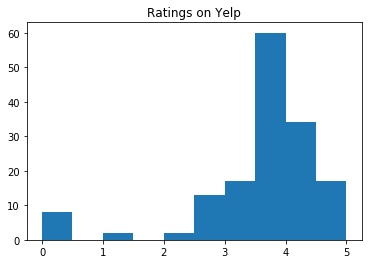

In [22]:
import matplotlib.pyplot as plt
plt.hist(yelp_df.rating_star)
plt.title('Ratings on Yelp')
plt.show()


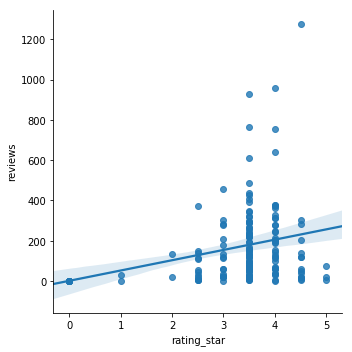

In [56]:
import seaborn as sns
sns.lmplot(data = yelp_df, x = 'rating_star', y = 'reviews')
plt.show()

In [25]:
import numpy as np
#Show average review by category for restaurants with > 10 reviews & sort by average rating
avg_ratings = []
for cat in cat_set:
    avg_ratings.append(round(np.mean(yelp_df['rating_star'][(yelp_df['reviews'] > 10) & (yelp_df[cat] == True)]), 1))

In [26]:
cat_df = pd.DataFrame()
cat_df['Category'] = list(cat_set)
cat_df['Avg_Rating'] = avg_ratings

In [28]:
cat_df.sort_values(by = 'Avg_Rating', ascending=False).head(10)

,Category,Avg_Rating
10,Modern European,4.5
12,Diners,4.5
28,Moroccan,4.5
35,Himalayan/Nepalese,4.1
36,Kosher,4.0
6,Food Trucks,4.0
32,Fast Food,4.0
23,American (New),4.0
1,Soup,3.9
18,Bars,3.9
